# AML - Training

In [1]:
## Check core SDK version number
import azureml.core
import mlflow
import os

from azureml.core import (Datastore, Dataset, Environment, Experiment, ScriptRunConfig,
                          Workspace)
from azureml.core.authentication import InteractiveLoginAuthentication
from IPython.display import display



print("[INFO] SDK version:", azureml.core.VERSION)

## due to diferent tenant -> typically customer tenant
# interactive_auth = InteractiveLoginAuthentication(tenant_id="72f988bf-86f1-41af-91ab-2d7cd011db47")

ws = Workspace.from_config()
print("[SUCCESS] LOGGED IN: ",ws.name, ws.resource_group, ws.location, ws.subscription_id, sep=' @ ')

## set mlflow backend to AML
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

print("[INFO] MLFlow wired to AML:", "experiments.azureml.net" in mlflow.get_tracking_uri())

[INFO] SDK version: 1.17.0
[SUCCESS] LOGGED IN:  @ mlops-demo @ mlops-rg @ westeurope @ 6ee947fa-0d77-4915-bf68-4a83a8bec2a4
[INFO] MLFlow wired to AML: True


## Config

In [54]:
aml_compute = "aml-cluster"
aml_ds = "aml_data"# "mmaadlsgen2_test"
# aml_dset = 'noa_weather'
# aml_dset = "oj_sample_data"
aml_dset = "diabetes_multiple"
aml_experiment = "mlflow-azureml"
loc_data = "data/demo_data"

In [55]:
## set the datastore
ds = ws.datastores[aml_ds]
print(f"[INFO] Datastore: {ds.name}, type: {ds.datastore_type}")

[INFO] Datastore: aml_data, type: AzureBlob


##  Data Prep

In [56]:
wtds = Dataset.get_by_name(ws, name=aml_dset)
# wtds = Dataset.get_by_name(ws, name='noa_weather')
pdf = wtds.to_pandas_dataframe()
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
AGE    442 non-null int64
SEX    442 non-null int64
BMI    442 non-null float64
BP     442 non-null float64
S1     442 non-null int64
S2     442 non-null float64
S3     442 non-null float64
S4     442 non-null float64
S5     442 non-null float64
S6     442 non-null int64
Y      442 non-null int64
dtypes: float64(6), int64(5)
memory usage: 38.1 KB


In [42]:
# !pip install seaborn

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

In [58]:
pdf.columns

Index(['AGE', 'SEX', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'Y'], dtype='object')

In [69]:
# target = "temperature" # diabetes
target = 'Y'

categorical_features_list = ['SEX', target]
quantitative_features_list = ['AGE', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', target]


In [70]:
cols_to_drop = [] # or empty
cols_at_end = [target]

In [71]:
pdf.drop(cols_to_drop,axis=1, inplace=True)

Let's just remove [] and the features with 30% or less NaN values

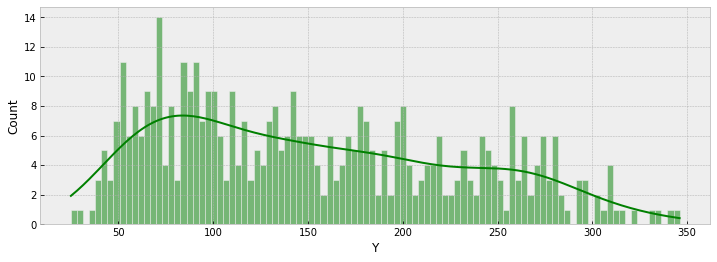

In [72]:
# print(df[target].describe())
plt.figure(figsize=(12, 4))
sns.histplot(pdf[target], color='g', bins=100, kde=True);

In [73]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(pdf, test_size=0.2, random_state=223)

print(f'train:{train.shape[0]} \ntest: {test.shape[0]}')

# final_df.to_csv("./data/taxi_final_df.csv", index=False)
# train.to_csv("./data/taxi_final_df_train.csv", index=False)
# test.to_csv("./data/taxi_final_df_test.csv", index=False)

train:353 
test: 89


## Training locally

In [74]:
mlflow.set_experiment(aml_experiment)

In [75]:
pdf[quantitative_features_list]

,AGE,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,32.1,101.00,157,93.2,38.0,4.00,4.8598,87,151
1,48,21.6,87.00,183,103.2,70.0,3.00,3.8918,69,75
2,72,30.5,93.00,156,93.6,41.0,4.00,4.6728,85,141
3,24,25.3,84.00,198,131.4,40.0,5.00,4.8903,89,206
4,50,23.0,101.00,192,125.4,52.0,4.00,4.2905,80,135
...,...,...,...,...,...,...,...,...,...,...
437,60,28.2,112.00,185,113.8,42.0,4.00,4.9836,93,178
438,47,24.9,75.00,225,166.0,42.0,5.00,4.4427,102,104
439,60,24.9,99.67,162,106.6,43.0,3.77,4.1271,95,132
440,36,30.0,95.00,201,125.2,42.0,4.79,5.1299,85,220


In [77]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import joblib

import lightgbm as lgb

# df = pdf[quantitative_features_list]
# y_df = df.pop(target)
# x_df = df

df = pdf
x_df = df
y_df = x_df.pop(target)

x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=223)

MLFlow Tracking

```python
mlflow.start_run()
# mlflow.log_param("x","abc")
mlflow.log_metric("x",123)
mlflow.end_run()
```

In [96]:
# Create a run object in the experiment
# run =  experiment.start_logging()
with mlflow.start_run():

    # Log the algorithm parameters to the run
    # run.log('num_leaves', 31)
    # run.log('learning_rate', 0.05)
    # run.log('n_estimators', 20)
    
    num_leaves=31
    learning_rate=0.01
    n_estimators=20
    
    mlflow.log_param("num_leaves",num_leaves)
    mlflow.log_param("learning_rate",learning_rate)
    mlflow.log_param("n_estimators",n_estimators)

    # setup model, train and test
    gbm = lgb.LGBMRegressor(num_leaves=num_leaves,
                            learning_rate=learning_rate,
                            n_estimators=n_estimators)
    model_gbm = gbm.fit(x_train, y_train,
            eval_set=[(x_test, y_test)],
            eval_metric='l1',
            early_stopping_rounds=5)

    preds = model_gbm.predict(x_test)

    # Output the Mean Squared Error to the notebook and to the run
    print('Mean Squared Error is', mean_squared_error(y_test, preds))
    # run.log('mse', mean_squared_error(y_test, preds))
    mlflow.log_metric('mse', mean_squared_error(y_test, preds))

#     # Save the model to the outputs directory for capture
#     model_file_name = './outputs/model.pkl'

#     joblib.dump(value = model_gbm, filename = model_file_name)

    mlflow.sklearn.log_model(model_gbm, "gbm_model")

    # upload the model file explicitly into artifacts 
    # run.upload_file(name = model_file_name, path_or_stream = model_file_name)


[1]	valid_0's l1: 65.8211	valid_0's l2: 6105.77
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 65.5622	valid_0's l2: 6053.79
[3]	valid_0's l1: 65.3047	valid_0's l2: 6002.82
[4]	valid_0's l1: 65.0654	valid_0's l2: 5953.24
[5]	valid_0's l1: 64.8129	valid_0's l2: 5904.35
[6]	valid_0's l1: 64.5664	valid_0's l2: 5857.38
[7]	valid_0's l1: 64.3249	valid_0's l2: 5809.65
[8]	valid_0's l1: 64.0882	valid_0's l2: 5764.71
[9]	valid_0's l1: 63.8544	valid_0's l2: 5718.75
[10]	valid_0's l1: 63.6322	valid_0's l2: 5673.9
[11]	valid_0's l1: 63.4115	valid_0's l2: 5631.83
[12]	valid_0's l1: 63.1895	valid_0's l2: 5589.66
[13]	valid_0's l1: 62.9683	valid_0's l2: 5546.54
[14]	valid_0's l1: 62.754	valid_0's l2: 5507.17
[15]	valid_0's l1: 62.5512	valid_0's l2: 5468.5
[16]	valid_0's l1: 62.3411	valid_0's l2: 5429.95
[17]	valid_0's l1: 62.1412	valid_0's l2: 5392.44
[18]	valid_0's l1: 61.9359	valid_0's l2: 5355.25
[19]	valid_0's l1: 61.7398	valid_0's l2: 5320.23
[20]	valid_0's l1: 61

### Inspect Experiment

In [80]:
experiment = Experiment(ws, aml_experiment)

List through individual `Run` metrics and sort output 

In [104]:
import pandas as pd

# children = list(parent_run.get_children())
metricslist = {}
for run in experiment.get_runs():
    if (run.status == "Completed"):
    #     properties = run.get_properties()
        metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    #     metricslist[int(properties['iteration'])] = metrics
    #     metricslist[run._run_number] = metrics
        metricslist[run.id] = metrics

rundata = pd.DataFrame(metricslist).T.sort_values(by=['mse'], ascending=False)
rundata

,mse,x
5cbfb046-929d-4cc7-93ec-ac747eaaa42e,5283.662482,NaN
ef5dbaff-d316-4408-bf0d-d11d108f40b8,3836.611915,NaN
e0e526fa-f7f1-4d9b-b83b-b6d7702bd92c,3836.611915,NaN
72597ec3-dd30-41bc-9b00-ff13bd0d63ff,NaN,123.0
1e5fe6dd-df1b-4ef1-a8b9-ce5e999135b2,NaN,NaN
b47f71bb-e169-49d7-8905-1f746ce579ff,NaN,NaN


Get the **best** run by metric

In [98]:
minimum_rmse_runid = None
minimum_rmse = None
num_runs_compared = 0
best_run = None

for run in experiment.get_runs():
    run_metrics = run.get_metrics()
    run_details = run.get_details()
    
    if (run.status == "Completed"):
        if ("mse" in run.get_metrics()):
            num_runs_compared += 1
            # each logged metric becomes a key in this returned dict
            run_rmse = run_metrics["mse"]
            run_id = run_details["runId"]

            if minimum_rmse is None:
                minimum_rmse = run_rmse
                minimum_rmse_runid = run_id
                best_run = run
            else:
                if run_rmse < minimum_rmse:
                    minimum_rmse = run_rmse
                    minimum_rmse_runid = run_id
                    best_run = run

print("Best run_id: " + minimum_rmse_runid)
print("Best run_id rmse: " + str(minimum_rmse))
print("Runs compared: " + str(num_runs_compared))

Best run_id: ef5dbaff-d316-4408-bf0d-d11d108f40b8
Best run_id rmse: 3836.61191487545
Runs compared: 3


In [107]:
best_run

Experiment,Id,Type,Status,Details Page,Docs Page
mlflow-azureml,ef5dbaff-d316-4408-bf0d-d11d108f40b8,,Completed,Link to Azure Machine Learning studio,Link to Documentation


## Training on AML Compute

In [109]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

compute_target = ComputeTarget(workspace=ws, name=aml_compute)
# Use the 'status' property to get a detailed status for the current cluster. 
cts = compute_target.status.serialize()
print(f'Found existing compute target: {aml_compute}\n({"cluster is running" if (int(cts["currentNodeCount"])>0) else "cluster is idle"}) currentNodeCount: {cts["currentNodeCount"]}, vmPriority: {cts["vmPriority"]}, vmSize: {cts["vmSize"]}')

Found existing compute target: aml-cluster
(cluster is running) currentNodeCount: 1, vmPriority: Dedicated, vmSize: STANDARD_D2_V2


In [110]:
import os
project_folder = "code/train/diabetes"

if not os.path.exists(project_folder):
    os.makedirs(project_folder)
else:
    print(f"folder '{project_folder}' aready there")

In [111]:
wtds = Dataset.get_by_name(ws, name=aml_dset)

In [136]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

conda_env = Environment('conda-env')
conda_env.python.conda_dependencies = CondaDependencies.create(pip_packages=['azureml-sdk',
                                                                             'azureml-dataprep[pandas,fuse]',
                                                                             'scikit-learn==0.22.2.post1',
                                                                             'azureml-mlflow',
                                                                             'lightgbm',
                                                                            'joblib'])

In [143]:
from azureml.core import ScriptRunConfig

src = ScriptRunConfig(source_directory=project_folder, 
                      script='train.py', 
                      arguments =[wtds.as_named_input('data')])

src.run_config.framework = 'python'
src.run_config.environment = conda_env
src.run_config.target = compute_target.name
# src.run_config.data_references = {ds.name: dr}

In [144]:
run = experiment.submit(config=src)

In [145]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…